<a href="https://colab.research.google.com/github/jmagdeska/mlai/blob/master/%5BMLAI%5D_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [24]:
!pip3 install 'keras'
!pip3 install 'seaborn'

**Import libraries**

In [0]:
import os
import sys
import shutil
import h5py
import numpy as np
import pandas as pd
from random import shuffle

from keras import layers
import keras.backend as K
from keras import optimizers
from keras import applications
from keras.models import Model
from keras.utils import plot_model
from keras.models import Sequential
from keras.utils import layer_utils
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.applications import xception
from keras.applications import InceptionResNetV2
from keras.applications import vgg16
from keras.applications import resnet

import pydot
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

np.random.seed(1000)
K.set_image_data_format('channels_last')

**Parameters**

In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
NUM_CLASSES = 120

**Utility Functions**

In [0]:
def create_model():
  model = Sequential()
  model.add(BatchNormalization(input_shape=(224, 224, 3)))
  model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(BatchNormalization())

  # model.add(GlobalAveragePooling2D())

  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.summary()

  return model

In [0]:
shutil.rmtree("train")
shutil.rmtree("test")
shutil.rmtree("valid")
shutil.rmtree("mlai")

**Dataset preparation**

In [6]:
# Clone github repository with data
if not os.path.isdir('./mlai/Images'):
  !git clone https://github.com/jmagdeska/mlai.git

DATA_DIR = 'mlai/Images'
class_samples = []
class_names = []

if not os.path.isdir('train'):
  os.mkdir('train')
if not os.path.isdir('valid'):
  os.mkdir('valid')
if not os.path.isdir('test'):
  os.mkdir('test')

for path, dirs, files in os.walk(DATA_DIR):
  dirs.sort(key = lambda x: x.lower())
  num_samples = len(files)  
  i = 0
  
  l = (int)(0.8*num_samples)
  if l != 0:  
    class_samples.append(num_samples)
    train_len = int(0.8*l)
    valid_len = l - train_len
    test_len = num_samples - l

    label = path.split("/")[2]
    class_names.append(label.split("-")[1])
    shuffle(files)
    for filename in files: 
      full_path = os.path.join(path, filename)       
      if i < train_len:   
        split = 'train'     
      elif i < (train_len + valid_len):
        split = 'valid'
      else:
        split = 'test'
      
      dir_name = os.path.join(split, label)
      if not os.path.isdir(dir_name):
        os.mkdir(os.path.join(split, label))
      shutil.move(full_path, dir_name)

      i += 1  

Cloning into 'mlai'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 41164 (delta 19), reused 3 (delta 0), pack-reused 41112
Receiving objects: 100% (41164/41164), 1.38 GiB | 44.09 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (20583/20583), done.


**Plot class distribution**

In [0]:
index = np.arange(len(class_names))
fig = plt.figure(figsize=(20,8))
plt.bar(index, class_samples)
plt.ylabel('Number of samples', fontsize=5)
plt.xlabel('Dog breeds', fontsize=5)
plt.xticks(index, class_names, rotation=90)
plt.title('Number of samples per dog breed')
plt.show()

**Dataset and Dataloader Preparation**

In [18]:
TRAIN_DIR = './train'
VALID_DIR = './valid'
TEST_DIR = './test'

datagen_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen_test = ImageDataGenerator(rescale=1./255)

generator_train = datagen_train.flow_from_directory(TRAIN_DIR, target_size=(224,224), batch_size=BATCH_SIZE, shuffle=True, class_mode='categorical')
generator_valid = datagen_test.flow_from_directory(VALID_DIR, target_size=(224, 224), batch_size=BATCH_SIZE, shuffle=True, class_mode='categorical')
generator_test = datagen_test.flow_from_directory(TEST_DIR, target_size=(224, 224), class_mode='categorical')

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


**Preview Data augmentation**

In [0]:
shutil.rmtree("preview")
img = load_img('/content/train/n02099601-golden_retriever/n02099601_3004.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape) 
os.mkdir("preview")

i = 0
for batch in datagen_train.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='augm'):
    i += 1
    if i > 5:
        break

j = 0
folder = "preview"
images = os.listdir(folder)
plt.figure(figsize=[14,10]) 
for image in images:
    plt.subplot(2,3,j+1)
    im = plt.imread(folder+"/"+image)
    j+=1
    imgplot = plt.imshow(im)
plt.show()

**Training with Custom model**

In [19]:
# ######## Custom model #########
my_model = create_model()
 
my_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9),
              metrics=['acc'])
history = my_model.fit_generator(generator_train, validation_data=generator_valid, epochs=NUM_EPOCHS,
                                    steps_per_epoch=generator_train.samples//BATCH_SIZE, 
                                    validation_steps=generator_valid.samples//BATCH_SIZE)                          

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_20 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 54, 54, 32)       

**Training with Resnet101 with Inception v4**

In [0]:
######## pretrained InceptionResNetV2 model ########
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

my_model = Sequential()
my_model.add(base_model)

# Add new layers
my_model.add(Flatten())
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(NUM_CLASSES, activation='softmax'))
base_model.trainable = False

# my_model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.Adam(lr=0.0001),
#               metrics=['acc'])
my_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9),
              metrics=['acc'])
history = my_model.fit_generator(generator_train, validation_data=generator_valid, epochs=NUM_EPOCHS,
                                    steps_per_epoch=generator_train.samples//BATCH_SIZE, 
                                    validation_steps=generator_valid.samples//BATCH_SIZE)                          

**Plot loss and accuracy**

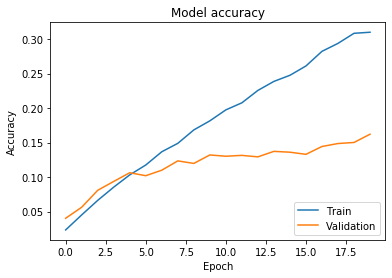

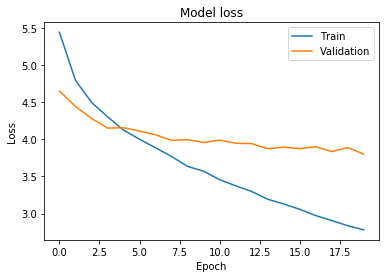

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

**Predicting test set**

Accuracy on test set is: 15.04


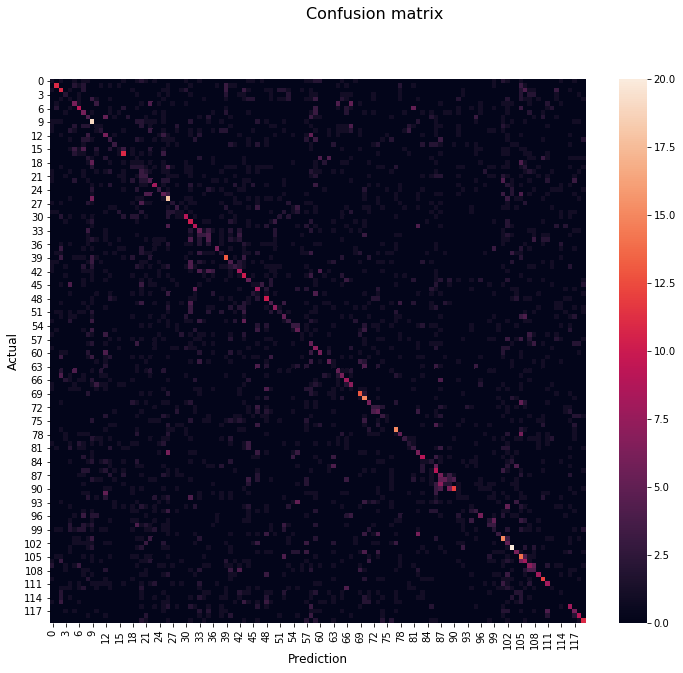

Classification Report
                                precision    recall  f1-score   support

                     Chihuahua       0.04      0.03      0.04        31
              Japanese_spaniel       0.48      0.30      0.37        37
                   Maltese_dog       0.19      0.22      0.20        51
                      Pekinese       0.12      0.07      0.09        30
                          Shih       0.03      0.02      0.02        43
              Blenheim_spaniel       0.18      0.16      0.17        38
                      papillon       0.26      0.23      0.24        40
                   toy_terrier       0.10      0.17      0.13        35
           Rhodesian_ridgeback       0.08      0.11      0.09        35
                  Afghan_hound       0.17      0.40      0.24        48
                        basset       0.04      0.03      0.03        35
                        beagle       0.11      0.05      0.07        39
                    bloodhound       0.10

In [43]:
#Confution Matrix and Classification Report
Y_pred = custom_model.predict_generator(generator_test)
y_pred = np.argmax(Y_pred, axis=1)
y_truth = generator_test.classes[generator_test.index_array]
print('Accuracy on test set is: %.2f' %(100*(y_pred == y_truth).sum()/len(y_truth)))

cm = confusion_matrix(y_truth, y_pred)
fig, ax = plt.subplots(1, 1, figsize=(12,10))
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])
sns.heatmap(cm)
fig.suptitle('Confusion matrix', fontsize=16)
plt.xlabel('Prediction', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

print('Classification Report')
print(classification_report(y_truth, y_pred, target_names=class_names))